<a href="https://colab.research.google.com/github/Billyjr2003/deep-learning/blob/master/Arabic_letters_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
os.environ["KAGGLE_USERNAME"] = "thebilly"
os.environ["KAGGLE_KEY"] = "b52cf6fb33415740f62bf9b1ad1190a1"
!kaggle competitions download -c arabic-letters-classification

 98% 194M/197M [00:02<00:00, 101MB/s]
100% 197M/197M [00:02<00:00, 93.6MB/s]


In [3]:
import zipfile

def unzip_folder(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
zip_file_path = '/content/arabic-letters-classification.zip'
extract_to = '/content/arabic-letters-classification_dataset'

unzip_folder(zip_file_path, extract_to)

In [153]:
def get_labels_from_directory(root_directory, label_position=-3, label_kind=-2, extension='.png'):
    directory_labels = {}
    class_names = []


    for subdir in os.listdir(root_directory):
        subdir_path = os.path.join(root_directory, subdir)


        if os.path.isdir(subdir_path):

            for file_name in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file_name)


                if os.path.isfile(file_path) and file_name.lower().endswith(extension):

                    label = file_name.split('_')[label_position].split('.')[0]
                    label_kind_name = file_name.split('_')[label_kind].split('.')[0]
                    result_label = " ".join([label, label_kind_name])


                    directory_labels[result_label] = int(subdir)
                    class_names.append(result_label)
                    break

    return directory_labels, sorted(class_names)



root_directory = '/content/arabic-letters-classification_dataset/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/train'
labels, class_names = get_labels_from_directory(root_directory)
print(labels)
# Print the directory names and their corresponding labels
# for directory, label in labels.items():
#     print(f"Directory: {directory}, Label: {label}")

{'lam alif': 30, 'qaf regular': 45, 'yaa middle': 63, 'dal end': 13, 'sad regular': 51, 'yaa regular': 64, 'lam regular': 34, 'sad end': 49, 'heh middle': 0, 'kaf begin': 26, 'heh end': 20, 'noon regular': 41, 'seen begin': 52, 'sad middle': 50, 'ain end': 3, 'feh middle': 17, 'ain regular': 5, 'kaf end': 27, 'beh regular': 12, 'meem begin': 35, 'beh begin': 9, 'dal regular': 14, 'kaf middle': 28, 'tah regular': 58, 'waw regular': 60, 'tah middle': 57, 'alif end': 6, 'feh end': 16, 'heh begin': 19, 'ain begin': 2, 'ain middle': 4, 'waw end': 59, 'meem end': 36, 'alif hamza': 7, 'raa regular': 47, 'kaf regular': 29, 'noon middle': 40, 'qaf middle': 44, 'lam end': 32, 'tah end': 56, 'jeem regular': 25, 'seen regular': 55, 'jeem begin': 22, 'seen end': 53, 'heh regular': 21, 'noon begin': 39, 'lam middle': 33, 'jeem end': 23, 'lam begin': 31, 'feh begin': 15, 'jeem middle': 24, 'qaf begin': 42, 'beh middle': 11, 'beh end': 10, 'meem regular': 38, 'noon end': 1, 'alif regular': 8, 'yaa end

In [154]:
import torch
from torchvision import  transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import random
import pathlib
from glob import glob

class ImageFolderCustom(Dataset):


    def __init__(self, targ_dir: str, split='train', transform=None, shuffle=True, seed=42):

        self.root_dir = targ_dir
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.png"))
        self.cls_to_idx, self.classes = get_labels_from_directory(self.root_dir)
        self.transform = transform
        self.split = split
        self.shuffle = shuffle

        if self.shuffle:

            if seed is not None:
                random.seed(seed)

            random.shuffle(self.paths)
        if self.split == 'train':

            train_size = int(0.9 * len(self.paths))
            self.paths = self.paths[:train_size]
        elif self.split == 'val':

            val_size = len(self.paths) - int(0.9 * len(self.paths))
            self.paths = self.paths[-val_size:]
    def __len__(self):
      return len(self.paths)

    def load_img(self, index):
      image = Image.open(str(self.paths[index])).convert("RGB")

      return image

    def __getitem__(self, index: int):
      img = self.load_img(index)
      label_name = str(self.paths[index]).split('_')[-3].split('.')[0]
      label_kind = str(self.paths[index]).split('_')[-2].split('.')[0]
      label_full_name = " ".join([label_name, label_kind])
      class_idx = self.cls_to_idx[label_full_name]
      if self.transform:
            return self.transform(img), class_idx
      else:
            return img, class_idx



In [155]:
class Threshold(object):
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, img):
        return (img > self.threshold).float()

In [238]:
train_transform= transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3)
    ], p=0.25),
    Threshold(threshold=0.7),



])
test_transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    Threshold(threshold=0.7),



])

In [245]:
target_dir = '/content/arabic-letters-classification_dataset/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/train'
train_data_custom = ImageFolderCustom(targ_dir=target_dir, split='train', transform=train_transform, shuffle=True, seed=42)
val_data_custom = ImageFolderCustom(targ_dir=target_dir, split='val', transform=test_transform, shuffle=False, seed=42)

In [253]:
train_dataloader = DataLoader(
      train_data_custom,
      batch_size=64,
      shuffle=True,
      num_workers=2,
      pin_memory=True,
  )
val_dataloader = DataLoader(
      val_data_custom,
      batch_size=64,
      shuffle=False,
      num_workers=2,
      pin_memory=True,
  )
class_names = train_data_custom.classes


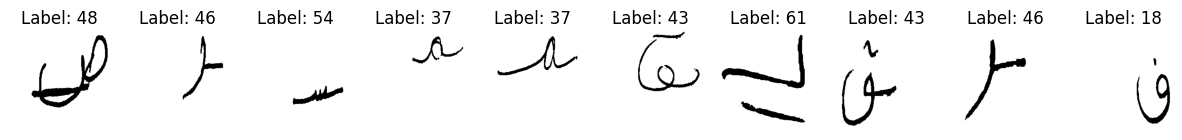

In [252]:
import matplotlib.pyplot as plt
def plot_random_images(data_loader, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        # Get a random batch from the DataLoader
        batch = next(iter(data_loader))
        images, labels = batch

        index = torch.randint(0, images.size(0), (1,)).item()
        image = images[index].squeeze().permute(1,2,0).numpy()
        label = labels[index].item()



        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

# Plot random images with labels
plot_random_images(val_dataloader)

In [251]:
import torch
from torch import nn
from tqdm.auto import tqdm
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):

    model.train()


    train_loss, train_acc = 0, 0





    for batch, (X, y) in tqdm(enumerate(dataloader), desc='training epoch'):


        X, y = X.to(device), y.to(device)


        y_pred = model(X)


        loss = loss_fn(y_pred, y)
        train_loss += loss.item()




        optimizer.zero_grad()


        loss.backward()


        optimizer.step()


        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)





    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):

    model.eval()


    test_loss, test_acc = 0, 0




    with torch.inference_mode():

        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)


            test_pred_logits = model(X)


            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()


            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))




    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          starting_epochs: int,
          epochs: int,
          device: torch.device,
          checkpoint_interval: int):

    print("Training Data Size:", len(train_dataloader.dataset))
    print("Test Data Size:", len(test_dataloader.dataset))

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    highest_train_accuracy = 0.0
    highest_test_accuracy = 0.0
    pbar = tqdm(total=epochs, initial=starting_epochs, dynamic_ncols=True, desc="Training")

    for epoch in range(starting_epochs, epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)


        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        if (epoch + 1) % checkpoint_interval == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'train_acc': train_acc,
                'test_loss': test_loss,
                'test_acc': test_acc
            }, f'checkpoint_epoch_last.pth')

        if train_acc > highest_train_accuracy:
          highest_train_accuracy = train_acc


        if test_acc > highest_test_accuracy:
          highest_test_accuracy = test_acc
          torch.save(model, '/content/arabic_letters_classifier.pth')
          torch.save(model.state_dict(), "/content/arabic_letters_classifier_param.pth")

        pbar.update(1)


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    print(
        f"Highest Train Accuracy: {highest_train_accuracy:.4f} | "
        f"Highest Test Accuracy: {highest_test_accuracy:.4f}"
        )

    return results

In [243]:
from torchvision import  models
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet50(pretrained=True).to(device)

num_classes = 65
classifier = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes),  ).to(device)
model.fc = classifier

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [254]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
NUM_EPOCHS = 10
start_epoch = 0
print(f"Starting from epoch: {start_epoch}")
model_result= train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=val_dataloader,
             loss_fn=criterion,
             optimizer=optimizer,
             starting_epochs= start_epoch,
             epochs=NUM_EPOCHS,
             device=device,
             checkpoint_interval=5)

Starting from epoch: 0
Training Data Size: 38303
Test Data Size: 4256


Training:   0%|          | 0/10 [00:00<?, ?it/s]

training epoch: 0it [00:00, ?it/s]

Epoch: 1 | train_loss: 2.8576 | train_acc: 0.3410 | test_loss: 1.0977 | test_acc: 0.8272


training epoch: 0it [00:00, ?it/s]

Epoch: 2 | train_loss: 0.7030 | train_acc: 0.8244 | test_loss: 0.3085 | test_acc: 0.9268


training epoch: 0it [00:00, ?it/s]

Epoch: 3 | train_loss: 0.3220 | train_acc: 0.9168 | test_loss: 0.1866 | test_acc: 0.9461


training epoch: 0it [00:00, ?it/s]

Epoch: 4 | train_loss: 0.2219 | train_acc: 0.9403 | test_loss: 0.1506 | test_acc: 0.9545


training epoch: 0it [00:00, ?it/s]

Epoch: 5 | train_loss: 0.1663 | train_acc: 0.9530 | test_loss: 0.0913 | test_acc: 0.9778


training epoch: 0it [00:00, ?it/s]

Epoch: 6 | train_loss: 0.1284 | train_acc: 0.9645 | test_loss: 0.0698 | test_acc: 0.9816


training epoch: 0it [00:00, ?it/s]

Epoch: 7 | train_loss: 0.1057 | train_acc: 0.9699 | test_loss: 0.0825 | test_acc: 0.9788


training epoch: 0it [00:00, ?it/s]

Epoch: 8 | train_loss: 0.0869 | train_acc: 0.9758 | test_loss: 0.0615 | test_acc: 0.9862


training epoch: 0it [00:00, ?it/s]

Epoch: 9 | train_loss: 0.0753 | train_acc: 0.9790 | test_loss: 0.0713 | test_acc: 0.9771


training epoch: 0it [00:00, ?it/s]

Epoch: 10 | train_loss: 0.0585 | train_acc: 0.9847 | test_loss: 0.0454 | test_acc: 0.9872
Highest Train Accuracy: 0.9847 | Highest Test Accuracy: 0.9872


In [260]:
import csv
test_data = '/content/arabic-letters-classification_dataset/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test'
csv_file = '/content/arabic_letters_predections.csv'
with open(csv_file, 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)

  writer.writerow(['Image_name', 'Label'])

  for file_name in os.listdir(test_data):
    if file_name.endswith(".jpg") or file_name.endswith(".png"):
      image_path = os.path.join(test_data, file_name)
      image = Image.open(image_path).convert('RGB')
      img_tensor = test_transform(image).unsqueeze(0)
      img_tensor = img_tensor.to(device)
      with torch.no_grad():
            output = model(img_tensor)

            predicted_class = torch.argmax(torch.softmax(output, dim=1), dim=1)

            writer.writerow([file_name, predicted_class.item()])


In [261]:
import pandas as pd
df = pd.read_csv(csv_file)
df.head(10)

,Image_name,Label
0,6538.png,44
1,7746.png,48
2,8625.png,56
3,979.png,12
4,1594.png,17
5,6808.png,46
6,1426.png,15
7,1081.png,13
8,3290.png,26
9,3639.png,28


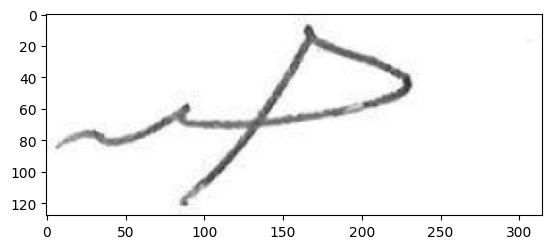

In [263]:
import cv2
img = cv2.imread('/content/arabic-letters-classification_dataset/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test/7746.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()